In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

os.getcwd()

'/Users/aneeshussain/Code/diss/analysis'

In [3]:
# Get the current directory
current_dir = os.getcwd()

# Change directory to the parent directory (diss)
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
os.chdir(parent_dir)

# Append the parent directory to the system path (optional, if you want to add it to the import path)
sys.path.append(parent_dir)

# Print the new current working directory to confirm the change
print(f"Changed directory to: {os.getcwd()}")

Changed directory to: /Users/aneeshussain/Code/diss


Total Open Transaction Costs: 1658004.95
Total Close Transaction Costs: 1662601.65
Total Transaction Costs (Open + Close): 3320606.60


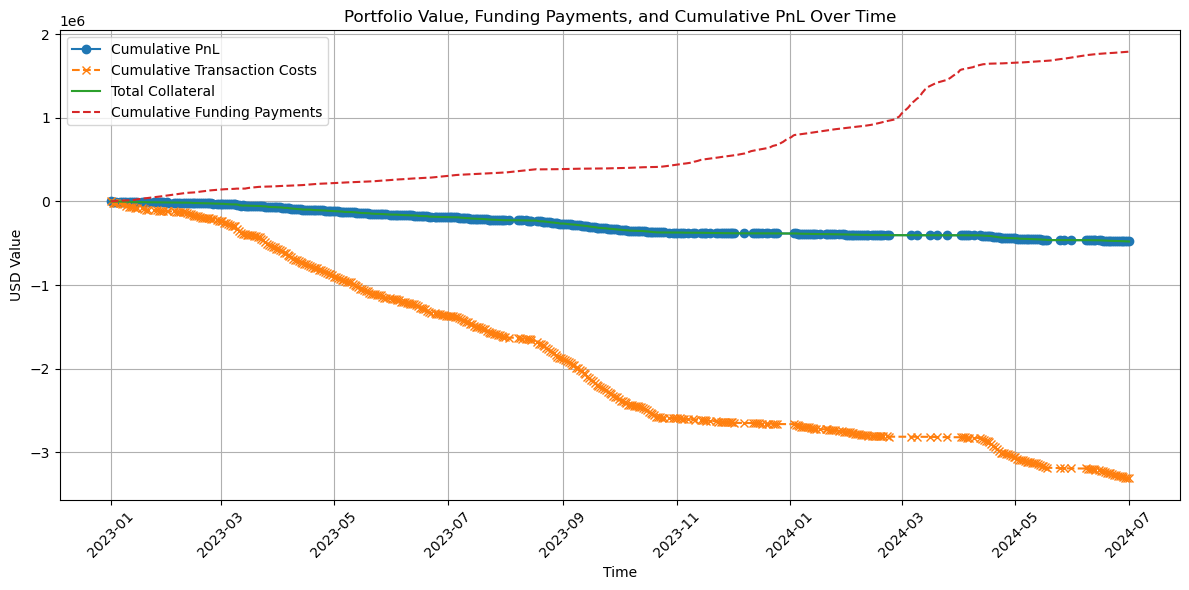

In [4]:
trades_filepath = './results/test1/trades_log.csv'
trades_df = pd.read_csv(trades_filepath)

# Convert 'close_time' to datetime and sort the trades by 'close_time'
trades_df['close_time'] = pd.to_datetime(trades_df['close_time'])
trades_df.sort_values(by='close_time', inplace=True)

# Extract date and calculate daily and cumulative PnL
trades_df['close_date'] = trades_df['close_time'].dt.date  # Get the date without time
daily_pnl = trades_df.groupby('close_date')['pnl'].sum()
cumulative_pnl = daily_pnl.cumsum()

# Calculate the total transaction cost (sum of open and close transaction costs)
trades_df['total_transaction_cost'] = trades_df['open_transaction_cost'] + trades_df['close_transaction_cost']

# Calculate the cumulative sum of transaction costs
daily_transaction_costs = trades_df.groupby('close_date')['total_transaction_cost'].sum()
cumulative_transaction_costs = daily_transaction_costs.cumsum()


# Load the collateral and funding payment CSV
collateral_filepath = './results/test1/collateral_log.csv'
df = pd.read_csv(collateral_filepath)

# Convert 'time' to datetime and set as index
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# Select the collateral columns to calculate the total collateral value
collateral_columns = [
    'binance_btc_collateral', 'binance_eth_collateral', 'binance_liquid_cash', 
    'okx_btc_collateral', 'okx_eth_collateral', 'okx_liquid_cash', 
    'bybit_btc_collateral', 'bybit_eth_collateral', 'bybit_liquid_cash'
]

# Calculate total collateral and funding payments
df['total_collateral'] = df[collateral_columns].sum(axis=1) - 10000000
df['total_funding_payments'] = df[['binance_funding', 'okx_funding', 'bybit_funding']].sum(axis=1)

total_open_transaction_cost = trades_df['open_transaction_cost'].sum()
total_close_transaction_cost = trades_df['close_transaction_cost'].sum()

# Print the sums
print(f"Total Open Transaction Costs: {total_open_transaction_cost:.2f}")
print(f"Total Close Transaction Costs: {total_close_transaction_cost:.2f}")

# Calculate and print the total transaction costs (open + close)
total_transaction_cost = total_open_transaction_cost + total_close_transaction_cost
print(f"Total Transaction Costs (Open + Close): {total_transaction_cost:.2f}")

# Plot the cumulative PnL, total collateral, and funding payments on the same graph
plt.figure(figsize=(12, 6))

# Plot cumulative PnL (using the close date as x-axis)
plt.plot(cumulative_pnl.index, cumulative_pnl.values, label='Cumulative PnL', marker='o')

# Plot cumulative transaction costs
plt.plot(cumulative_transaction_costs.index, -cumulative_transaction_costs.values, label='Cumulative Transaction Costs', linestyle='--', marker='x')


# Plot total collateral
plt.plot(df.index, df['total_collateral'], label='Total Collateral', linestyle='-')

# Plot cumulative funding payments
plt.plot(df.index, df['total_funding_payments'], label='Cumulative Funding Payments', linestyle='--')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('USD Value')
plt.title('Portfolio Value, Funding Payments, and Cumulative PnL Over Time')
plt.grid(True)
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [4]:
# rf_df = pd.read_excel('./data/raw/Search.xlsx')

# # Create a new DataFrame with only the transformed Date and Rate columns
# new_df = pd.DataFrame()
# new_df['date'] = pd.to_datetime(rf_df['Effective Date'])
# new_df['rate'] = rf_df['Rate (%)'] / 100

# # Sort the DataFrame by date in ascending order
# new_df = new_df.sort_values('date')

# # Create a date range that covers all dates between the min and max date in the data
# all_dates = pd.date_range(start=new_df['date'].min(), end=new_df['date'].max())

# # Reindex the DataFrame to include all dates, forward fill the missing rates
# new_df = new_df.set_index('date').reindex(all_dates).fillna(method='ffill')

# # Reset the index and rename the index column back to 'Effective Date'
# new_df = new_df.rename_axis('date').reset_index()

# new_df.to_csv('./data/processed/risk_free_rate.csv', index=False)

/Applications/anaconda3/envs/sklearn0242/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/var/folders/mf/b67_blxs1rj380h3rh2kgtlh0000gn/T/ipykernel_65652/2324242968.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_df = new_df.set_index('date').reindex(all_dates).fillna(method='ffill')
